# CellViT Classification Dataset — Patch and Label Generation

**Purpose:**  
This notebook prepares **512×512 classification patches** specifically for  
the *CellViT classification head*. Each patch contains cropped H&E tissue  
and a corresponding label file listing nucleus centers and classes.

---

### What It Does
1. Loads processed maps (`inst_map`, `type_map`) from `whole_slide/`.
2. Locates the corresponding RGB `.svs` or `.tif` image.
3. Tiles the slide into non-overlapping 512×512 patches.
4. For each patch:
   - Saves an RGB patch (`.png`)
   - Extracts nucleus centroids and class IDs → saves as `.csv`
5. Produces a clean folder structure compatible with CellViT’s training pipeline.

---

### Output Folder Structure
ProcessedDataset/

└── v1_40x_area20/

└── patches_cellvit_p512/

├── images/ ← 512×512 cropped RGB patches

├── labels/ ← matching .csv files with x,y,class

├── debug/ ← visualization or QA exports

└── _meta/ ← configuration and logs


---

### Table of Contents
- [Step 1 — Setup and Folder Creation](#step1)
- [Step 2 — Patch Extraction and Label Generation](#step2)
- [Step 3 — Visual Inspection of Generated Patches](#step3)
- [Step 4 — Summary and Quality Checks](#step4)
- [Step 5 — Dataset Integrity + Overview](#step5)


<a id="step1"></a>
# Step 1 — Setup and Folder Creation


In [1]:
from pathlib import Path
import json
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

# --- Config ---
PROJECT_ROOT = Path("/projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis")
PROC_ROOT = PROJECT_ROOT / "ProcessedDataset/v1_40x_area20"
PATCH_SIZE = 512
TASK_NAME = f"patches_cellvit_p{PATCH_SIZE}"

# --- Input directories ---
RAW_IMG_ROOT = PROJECT_ROOT / "Datasets/BU_course_data/TrainingData/TrainingImages_and_Annotations"
INST_DIR = PROC_ROOT / "whole_slide/inst_maps"
TYPE_DIR = PROC_ROOT / "whole_slide/type_maps"

# --- Output directories ---
PATCH_ROOT = PROC_ROOT / TASK_NAME
(PATCH_ROOT / "images").mkdir(parents=True, exist_ok=True)
(PATCH_ROOT / "labels").mkdir(parents=True, exist_ok=True)
(PATCH_ROOT / "debug").mkdir(parents=True, exist_ok=True)
(PATCH_ROOT / "_meta").mkdir(parents=True, exist_ok=True)

# --- Metadata loading ---
with open(PROC_ROOT / "_meta/class_map.json", "r") as f:
    class_map = json.load(f)

# --- Record run parameters ---
params = {
    "task": "cellvit_classification_head",
    "patch_size": PATCH_SIZE,
    "input_root": str(PROC_ROOT),
    "output_root": str(PATCH_ROOT),
    "num_classes": len(class_map),
    "class_map": class_map,
}

with open(PATCH_ROOT / "_meta/params.json", "w") as f:
    json.dump(params, f, indent=2)

# --- Confirmation ---
print(f"✅ Initialized output structure for CellViT classification patches:")
print(f"  → {PATCH_ROOT}")
print(f"  Classes: {list(class_map.values())}")


✅ Initialized output structure for CellViT classification patches:
  → /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/patches_cellvit_p512
  Classes: ['background', 'epithelial', 'lymphocyte', 'macrophage', 'neutrophil']


<a id="step2"></a>
# Step 2 — Patch Extraction and Label Generation

In [2]:
from skimage.measure import regionprops
import cv2
from openslide import OpenSlide

def find_image_path(slide_name: str) -> Path | None:
    """
    Locate the corresponding .svs (preferred) or .tif file for a given slide.
    """
    for patient_dir in sorted(RAW_IMG_ROOT.iterdir()):
        if not patient_dir.is_dir():
            continue
        for ext in (".svs", ".tif"):
            candidate = patient_dir / f"{slide_name}{ext}"
            if candidate.exists():
                return candidate
    return None


def load_rgb_image(img_path: Path) -> np.ndarray:
    """
    Load RGB image using OpenSlide (.svs) or OpenCV (.tif).
    """
    if img_path.suffix.lower() == ".svs":
        with OpenSlide(str(img_path)) as slide:
            w, h = slide.level_dimensions[0]
            rgb = np.array(slide.read_region((0, 0), 0, (w, h)))[:, :, :3]
        return rgb
    else:
        img = cv2.imread(str(img_path))
        if img is None:
            raise RuntimeError(f"Failed to load {img_path}")
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


def extract_patch_labels(inst_map: np.ndarray, type_map: np.ndarray):
    """
    Return (x, y, class_id) for each nucleus centroid.
    """
    rows = []
    for region in regionprops(inst_map):
        y, x = region.centroid
        cls_vals = type_map[inst_map == region.label]
        if cls_vals.size == 0:
            continue
        cls = int(np.bincount(cls_vals).argmax())  # majority vote
        if cls == 0:
            continue  # skip background
        rows.append((int(x), int(y), cls))
    return rows


# --- Main loop ---
slides = sorted([p.stem.replace("_inst", "") for p in INST_DIR.glob("*_inst.npy")])
print(f"Found {len(slides)} processed slides.")

for slide_name in tqdm(slides, desc="Generating patches"):
    inst_path = INST_DIR / f"{slide_name}_inst.npy"
    type_path = TYPE_DIR / f"{slide_name}_type.npy"

    if not inst_path.exists() or not type_path.exists():
        print(f"⚠️ Missing maps for {slide_name}")
        continue

    try:
        inst_map = np.load(inst_path)
        type_map = np.load(type_path)
        img_path = find_image_path(slide_name)
        if img_path is None:
            print(f"⚠️ No image found for {slide_name}")
            continue
        rgb = load_rgb_image(img_path)

        h, w = rgb.shape[:2]
        saved_count = 0

        for y in range(0, h, PATCH_SIZE):
            for x in range(0, w, PATCH_SIZE):
                patch_rgb = rgb[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
                patch_inst = inst_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE]
                patch_type = type_map[y:y+PATCH_SIZE, x:x+PATCH_SIZE]

                if patch_rgb.shape[0] != PATCH_SIZE or patch_rgb.shape[1] != PATCH_SIZE:
                    continue  # skip incomplete edge tiles

                # skip empty patches
                if np.count_nonzero(patch_inst) == 0:
                    continue

                # extract centers
                centers = extract_patch_labels(patch_inst, patch_type)
                if not centers:
                    continue

                # save patch
                img_name = f"{slide_name}_{x}_{y}.png"
                csv_name = f"{slide_name}_{x}_{y}.csv"

                cv2.imwrite(str(PATCH_ROOT / "images" / img_name), cv2.cvtColor(patch_rgb, cv2.COLOR_RGB2BGR))
                pd.DataFrame(centers, columns=["x", "y", "class"]).to_csv(
                    PATCH_ROOT / "labels" / csv_name, index=False, header=False
                )
                saved_count += 1

        print(f"Saved {saved_count} patches from {slide_name}")

    except Exception as e:
        print(f"⚠️ Error in {slide_name}: {e}")

print("✅ Patch generation complete.")


Found 209 processed slides.


Generating patches:   1%|          | 2/209 [00:00<01:03,  3.26it/s]

Saved 4 patches from TCGA-55-1594-01Z-00-DX1_001
Saved 1 patches from TCGA-55-1594-01Z-00-DX1_002


Generating patches:   2%|▏         | 4/209 [00:00<00:37,  5.53it/s]

Saved 1 patches from TCGA-55-1594-01Z-00-DX1_003
Saved 1 patches from TCGA-55-1594-01Z-00-DX1_004


Generating patches:   2%|▏         | 5/209 [00:01<00:33,  6.17it/s]

Saved 1 patches from TCGA-55-1594-01Z-00-DX1_005


Generating patches:   3%|▎         | 7/209 [00:01<00:37,  5.37it/s]

Saved 4 patches from TCGA-5P-A9K0-01Z-00-DX1_1
Saved 1 patches from TCGA-5P-A9K0-01Z-00-DX1_2
Saved 0 patches from TCGA-5P-A9K0-01Z-00-DX1_3


Generating patches:   5%|▍         | 10/209 [00:01<00:25,  7.82it/s]

Saved 1 patches from TCGA-69-7760-01Z-00-DX1_001
Saved 1 patches from TCGA-69-7760-01Z-00-DX1_002


Generating patches:   5%|▌         | 11/209 [00:01<00:24,  8.08it/s]

Saved 1 patches from TCGA-69-7760-01Z-00-DX1_003


Generating patches:   6%|▌         | 12/209 [00:02<00:44,  4.42it/s]

Saved 4 patches from TCGA-69-7760-01Z-00-DX1_004
Saved 0 patches from TCGA-69-A59K-01Z-00-DX1_001
Saved 0 patches from TCGA-69-A59K-01Z-00-DX1_002


Generating patches:   7%|▋         | 15/209 [00:03<01:10,  2.75it/s]

Saved 8 patches from TCGA-69-A59K-01Z-00-DX1_003


Generating patches:   8%|▊         | 17/209 [00:04<00:58,  3.27it/s]

Saved 1 patches from TCGA-69-A59K-01Z-00-DX1_004
Saved 1 patches from TCGA-73-4668-01Z-00-DX1_001


Generating patches:  10%|▉         | 20/209 [00:04<00:45,  4.12it/s]

Saved 4 patches from TCGA-73-4668-01Z-00-DX1_002
Saved 0 patches from TCGA-73-4668-01Z-00-DX1_003
Saved 0 patches from TCGA-73-4668-01Z-00-DX1_004


Generating patches:  11%|█         | 22/209 [00:05<00:34,  5.42it/s]

Saved 1 patches from TCGA-78-7220-01Z-00-DX1_001
Saved 1 patches from TCGA-78-7220-01Z-00-DX1_002


Generating patches:  11%|█▏        | 24/209 [00:05<00:40,  4.60it/s]

Saved 4 patches from TCGA-78-7220-01Z-00-DX1_003
Saved 1 patches from TCGA-78-7220-01Z-00-DX1_004


Generating patches:  12%|█▏        | 25/209 [00:05<00:34,  5.27it/s]

Saved 0 patches from TCGA-86-7713-01Z-00-DX1_001


Generating patches:  12%|█▏        | 26/209 [00:05<00:35,  5.12it/s]

Saved 1 patches from TCGA-86-7713-01Z-00-DX1_002


Generating patches:  13%|█▎        | 27/209 [00:06<00:38,  4.78it/s]

Saved 1 patches from TCGA-86-7713-01Z-00-DX1_003


Generating patches:  13%|█▎        | 28/209 [00:06<00:53,  3.38it/s]

Saved 2 patches from TCGA-86-7713-01Z-00-DX1_004


Generating patches:  14%|█▍        | 29/209 [00:06<00:49,  3.63it/s]

Saved 1 patches from TCGA-86-8672-01Z-00-DX1_1


Generating patches:  14%|█▍        | 30/209 [00:07<01:08,  2.61it/s]

Saved 3 patches from TCGA-86-8672-01Z-00-DX1_2


Generating patches:  15%|█▌        | 32/209 [00:08<01:11,  2.46it/s]

Saved 4 patches from TCGA-86-8672-01Z-00-DX1_3
Saved 1 patches from TCGA-A2-A0CV-01Z-00-DX1_1


Generating patches:  16%|█▌        | 33/209 [00:08<00:59,  2.95it/s]

Saved 1 patches from TCGA-A2-A0CV-01Z-00-DX1_2
Saved 0 patches from TCGA-A2-A0CV-01Z-00-DX1_3


Generating patches:  17%|█▋        | 35/209 [00:09<00:43,  4.03it/s]

Saved 1 patches from TCGA-A2-A0CV-01Z-00-DX1_4
Saved 0 patches from TCGA-A2-A0CV-01Z-00-DX1_5
Saved 0 patches from TCGA-A2-A0ES-01Z-00-DX1_1


Generating patches:  18%|█▊        | 38/209 [00:09<00:35,  4.89it/s]

Saved 2 patches from TCGA-A2-A0ES-01Z-00-DX1_2
Saved 0 patches from TCGA-A2-A0ES-01Z-00-DX1_3


Generating patches:  19%|█▉        | 40/209 [00:09<00:31,  5.32it/s]

Saved 1 patches from TCGA-A2-A0ES-01Z-00-DX1_4
Saved 0 patches from TCGA-A2-A0ES-01Z-00-DX1_5


Generating patches:  22%|██▏       | 45/209 [00:10<00:30,  5.42it/s]

Saved 6 patches from TCGA-B6-A0WZ-01Z-00-DX1_1
Saved 0 patches from TCGA-B6-A0WZ-01Z-00-DX1_2
Saved 0 patches from TCGA-B6-A0WZ-01Z-00-DX1_3
Saved 0 patches from TCGA-B6-A0WZ-01Z-00-DX1_4


Generating patches:  22%|██▏       | 47/209 [00:11<00:26,  6.03it/s]

Saved 1 patches from TCGA-B6-A0WZ-01Z-00-DX1_5
Saved 0 patches from TCGA-B6-A0WZ-01Z-00-DX1_6
Saved 0 patches from TCGA-B9-A44B-01Z-00-DX1_1


Generating patches:  23%|██▎       | 49/209 [00:11<00:26,  5.98it/s]

Saved 4 patches from TCGA-B9-A44B-01Z-00-DX1_2
Saved 0 patches from TCGA-B9-A44B-01Z-00-DX1_3


Generating patches:  25%|██▍       | 52/209 [00:11<00:25,  6.20it/s]

Saved 4 patches from TCGA-B9-A8YI-01Z-00-DX1_1
Saved 2 patches from TCGA-B9-A8YI-01Z-00-DX1_2


Generating patches:  25%|██▌       | 53/209 [00:12<00:32,  4.81it/s]

Saved 6 patches from TCGA-B9-A8YI-01Z-00-DX1_3
Saved 0 patches from TCGA-B9-A8YI-01Z-00-DX1_4
Saved 0 patches from TCGA-B9-A8YI-01Z-00-DX1_5


Generating patches:  27%|██▋       | 57/209 [00:13<00:29,  5.24it/s]

Saved 2 patches from TCGA-BH-A18T-01Z-00-DX1_1
Saved 1 patches from TCGA-BH-A18T-01Z-00-DX1_2


Generating patches:  28%|██▊       | 59/209 [00:13<00:22,  6.76it/s]

Saved 0 patches from TCGA-BH-A18T-01Z-00-DX1_3
Saved 0 patches from TCGA-BH-A18T-01Z-00-DX1_4


Generating patches:  29%|██▊       | 60/209 [00:13<00:25,  5.84it/s]

Saved 1 patches from TCGA-BH-A18T-01Z-00-DX1_5


Generating patches:  29%|██▉       | 61/209 [00:13<00:35,  4.11it/s]

Saved 2 patches from TCGA-BH-A18T-01Z-00-DX1_6
Saved 0 patches from TCGA-D8-A1X5-01Z-00-DX2_1


Generating patches:  30%|███       | 63/209 [00:14<00:31,  4.59it/s]

Saved 4 patches from TCGA-D8-A1X5-01Z-00-DX2_2


Generating patches:  31%|███       | 65/209 [00:14<00:32,  4.40it/s]

Saved 6 patches from TCGA-D8-A1X5-01Z-00-DX2_3
Saved 1 patches from TCGA-D8-A1X5-01Z-00-DX2_4


Generating patches:  32%|███▏      | 67/209 [00:15<00:27,  5.21it/s]

Saved 1 patches from TCGA-DW-7841-01Z-00-DX1_1
Saved 1 patches from TCGA-DW-7841-01Z-00-DX1_2
Saved 0 patches from TCGA-DW-7841-01Z-00-DX1_3
Saved 0 patches from TCGA-E2-A154-01Z-00-DX1_1


Generating patches:  34%|███▍      | 71/209 [00:15<00:13,  9.87it/s]

Saved 0 patches from TCGA-E2-A154-01Z-00-DX1_2
Saved 1 patches from TCGA-E2-A154-01Z-00-DX1_3


Generating patches:  35%|███▍      | 73/209 [00:15<00:14,  9.52it/s]

Saved 1 patches from TCGA-E2-A154-01Z-00-DX1_4
Saved 0 patches from TCGA-E2-A154-01Z-00-DX1_5
Saved 0 patches from TCGA-E2-A154-01Z-00-DX1_6
Saved 0 patches from TCGA-E2-A154-01Z-00-DX1_7
Saved 0 patches from TCGA-E2-A154-01Z-00-DX1_8


Generating patches:  37%|███▋      | 78/209 [00:16<00:21,  6.06it/s]

Saved 6 patches from TCGA-E9-A22B-01Z-00-DX1_1
Saved 1 patches from TCGA-E9-A22B-01Z-00-DX1_2


Generating patches:  40%|███▉      | 83/209 [00:16<00:12,  9.74it/s]

Saved 1 patches from TCGA-E9-A22B-01Z-00-DX1_3
Saved 0 patches from TCGA-E9-A22B-01Z-00-DX1_4
Saved 0 patches from TCGA-E9-A22B-01Z-00-DX1_5
Saved 0 patches from TCGA-E9-A22B-01Z-00-DX1_6
Saved 0 patches from TCGA-E9-A22B-01Z-00-DX1_7
Saved 2 patches from TCGA-E9-A22B-01Z-00-DX1_8


Generating patches:  41%|████      | 85/209 [00:17<00:20,  6.07it/s]

Saved 1 patches from TCGA-E9-A22G-01Z-00-DX1_1


Generating patches:  42%|████▏     | 87/209 [00:17<00:19,  6.36it/s]

Saved 1 patches from TCGA-E9-A22G-01Z-00-DX1_2
Saved 0 patches from TCGA-E9-A22G-01Z-00-DX1_3
Saved 0 patches from TCGA-E9-A22G-01Z-00-DX1_4


Generating patches:  43%|████▎     | 89/209 [00:18<00:17,  6.75it/s]

Saved 1 patches from TCGA-E9-A22G-01Z-00-DX1_5


Generating patches:  43%|████▎     | 90/209 [00:18<00:24,  4.95it/s]

Saved 6 patches from TCGA-EJ-5495-01Z-00-DX1-1
Saved 0 patches from TCGA-EJ-5495-01Z-00-DX1-2
Saved 0 patches from TCGA-EJ-5495-01Z-00-DX1-3
Saved 0 patches from TCGA-EJ-5495-01Z-00-DX1-4


Generating patches:  47%|████▋     | 99/209 [00:19<00:09, 12.00it/s]

Saved 2 patches from TCGA-EJ-5505-01Z-00-DX1-1
Saved 0 patches from TCGA-EJ-5505-01Z-00-DX1-2
Saved 0 patches from TCGA-EJ-5505-01Z-00-DX1-3
Saved 0 patches from TCGA-EJ-5505-01Z-00-DX1-4
Saved 0 patches from TCGA-EJ-5505-01Z-00-DX1-5
Saved 0 patches from TCGA-EJ-5505-01Z-00-DX1-6
Saved 0 patches from TCGA-EJ-5517-01Z-00-DX1-1
Saved 0 patches from TCGA-EJ-5517-01Z-00-DX1-2


Generating patches:  49%|████▉     | 102/209 [00:19<00:07, 13.89it/s]

Saved 1 patches from TCGA-EJ-5517-01Z-00-DX1-3
Saved 9 patches from TCGA-EJ-5517-01Z-00-DX1-4
Saved 2 patches from TCGA-EV-5903-01Z-00-DX1_1


Generating patches:  50%|█████     | 105/209 [00:20<00:14,  7.30it/s]

Saved 0 patches from TCGA-EV-5903-01Z-00-DX1_2
Saved 0 patches from TCGA-EV-5903-01Z-00-DX1_3
Saved 0 patches from TCGA-EV-5903-01Z-00-DX1_4
Saved 0 patches from TCGA-EV-5903-01Z-00-DX1_5
Saved 0 patches from TCGA-EW-A6SD-01Z-00-DX1_1
Saved 0 patches from TCGA-EW-A6SD-01Z-00-DX1_2


Generating patches:  53%|█████▎    | 111/209 [00:20<00:10,  9.08it/s]

Saved 2 patches from TCGA-EW-A6SD-01Z-00-DX1_3


Generating patches:  54%|█████▍    | 113/209 [00:20<00:12,  7.95it/s]

Saved 1 patches from TCGA-EW-A6SD-01Z-00-DX1_4
Saved 0 patches from TCGA-EW-A6SD-01Z-00-DX1_5


Generating patches:  55%|█████▌    | 115/209 [00:21<00:11,  8.33it/s]

Saved 2 patches from TCGA-F9-A97G-01Z-00-DX1_1
Saved 0 patches from TCGA-F9-A97G-01Z-00-DX1_2
Saved 1 patches from TCGA-F9-A97G-01Z-00-DX1_3


Generating patches:  59%|█████▉    | 123/209 [00:21<00:06, 13.79it/s]

Saved 0 patches from TCGA-F9-A97G-01Z-00-DX1_4
Saved 0 patches from TCGA-G7-A8LD-01Z-00-DX1_1
Saved 0 patches from TCGA-G7-A8LD-01Z-00-DX1_10
Saved 0 patches from TCGA-G7-A8LD-01Z-00-DX1_2
Saved 0 patches from TCGA-G7-A8LD-01Z-00-DX1_3
Saved 0 patches from TCGA-G7-A8LD-01Z-00-DX1_4
Saved 1 patches from TCGA-G7-A8LD-01Z-00-DX1_5
Saved 0 patches from TCGA-G7-A8LD-01Z-00-DX1_6


Generating patches:  61%|██████    | 127/209 [00:21<00:04, 17.30it/s]

Saved 0 patches from TCGA-G7-A8LD-01Z-00-DX1_7
Saved 0 patches from TCGA-G7-A8LD-01Z-00-DX1_8
Saved 0 patches from TCGA-G7-A8LD-01Z-00-DX1_9
Saved 0 patches from TCGA-G9-6342-01Z-00-DX1-1
Saved 0 patches from TCGA-G9-6342-01Z-00-DX1-2


Generating patches:  62%|██████▏   | 130/209 [00:21<00:04, 17.72it/s]

Saved 2 patches from TCGA-G9-6499-01Z-00-DX1-1
Saved 0 patches from TCGA-G9-6499-01Z-00-DX1-2
Saved 0 patches from TCGA-G9-6499-01Z-00-DX1-3


Generating patches:  65%|██████▍   | 135/209 [00:22<00:05, 13.69it/s]

Saved 4 patches from TCGA-G9-6499-01Z-00-DX1-4
Saved 0 patches from TCGA-G9-6499-01Z-00-DX1-5
Saved 1 patches from TCGA-J4-A67Q-01Z-00-DX1-1
Saved 0 patches from TCGA-J4-A67Q-01Z-00-DX1-2
Saved 0 patches from TCGA-J4-A67Q-01Z-00-DX1-3


Generating patches:  67%|██████▋   | 140/209 [00:22<00:03, 18.93it/s]

Saved 0 patches from TCGA-J4-A67Q-01Z-00-DX1-4
Saved 0 patches from TCGA-J4-A67Q-01Z-00-DX1-5
Saved 0 patches from TCGA-J4-A67T-01Z-00-DX1-1


Generating patches:  68%|██████▊   | 143/209 [00:22<00:03, 18.20it/s]

Saved 2 patches from TCGA-J4-A67T-01Z-00-DX1-2
Saved 0 patches from TCGA-J4-A67T-01Z-00-DX1-3
Saved 0 patches from TCGA-J4-A67T-01Z-00-DX1-4
Saved 0 patches from TCGA-J4-A67T-01Z-00-DX1-5
Saved 1 patches from TCGA-J4-A67T-01Z-00-DX1-6


Generating patches:  71%|███████▏  | 149/209 [00:22<00:03, 16.67it/s]

Saved 1 patches from TCGA-KK-A59X-01Z-00-DX1-1
Saved 0 patches from TCGA-KK-A59X-01Z-00-DX1-2
Saved 0 patches from TCGA-KK-A59X-01Z-00-DX1-3
Saved 1 patches from TCGA-KK-A6E0-01Z-00-DX1-1


Generating patches:  72%|███████▏  | 151/209 [00:23<00:03, 14.80it/s]

Saved 2 patches from TCGA-KK-A6E0-01Z-00-DX1-2
Saved 0 patches from TCGA-KK-A6E0-01Z-00-DX1-3
Saved 0 patches from TCGA-KK-A6E0-01Z-00-DX1-4
Saved 0 patches from TCGA-KK-A6E0-01Z-00-DX1-5


Generating patches:  74%|███████▎  | 154/209 [00:23<00:03, 14.99it/s]

Saved 1 patches from TCGA-KK-A7AW-01Z-00-DX1-1


Generating patches:  75%|███████▍  | 156/209 [00:23<00:04, 11.09it/s]

Saved 1 patches from TCGA-L4-A4E5-01Z-00-DX1_1
Saved 0 patches from TCGA-L4-A4E5-01Z-00-DX1_2


Generating patches:  76%|███████▌  | 158/209 [00:24<00:05,  9.63it/s]

Saved 1 patches from TCGA-L4-A4E5-01Z-00-DX1_3
Saved 0 patches from TCGA-MH-A560-01Z-00-DX2_1


Generating patches:  77%|███████▋  | 160/209 [00:24<00:06,  7.44it/s]

Saved 6 patches from TCGA-MH-A560-01Z-00-DX2_2
Saved 0 patches from TCGA-MH-A560-01Z-00-DX2_3
Saved 0 patches from TCGA-MH-A560-01Z-00-DX2_4
Saved 0 patches from TCGA-MP-A4SY-01Z-00-DX1_1


Generating patches:  78%|███████▊  | 163/209 [00:25<00:07,  6.24it/s]

Saved 4 patches from TCGA-MP-A4SY-01Z-00-DX1_2


Generating patches:  79%|███████▉  | 166/209 [00:25<00:05,  7.32it/s]

Saved 1 patches from TCGA-MP-A4SY-01Z-00-DX1_3
Saved 0 patches from TCGA-MP-A4SY-01Z-00-DX1_4
Saved 0 patches from TCGA-MP-A4T7-01Z-00-DX1_1
Saved 0 patches from TCGA-MP-A4T7-01Z-00-DX1_2


Generating patches:  81%|████████  | 169/209 [00:25<00:05,  6.77it/s]

Saved 1 patches from TCGA-MP-A4T7-01Z-00-DX1_3
Saved 0 patches from TCGA-MP-A4T7-01Z-00-DX1_4
Saved 0 patches from TCGA-P4-AAVK-01Z-00-DX1_1
Saved 0 patches from TCGA-P4-AAVK-01Z-00-DX1_2


Generating patches:  82%|████████▏ | 172/209 [00:26<00:05,  6.34it/s]

Saved 6 patches from TCGA-P4-AAVK-01Z-00-DX1_3
Saved 0 patches from TCGA-P4-AAVK-01Z-00-DX1_4
Saved 0 patches from TCGA-P4-AAVK-01Z-00-DX1_5
Saved 0 patches from TCGA-P4-AAVK-01Z-00-DX1_6
Saved 0 patches from TCGA-P4-AAVK-01Z-00-DX1_7


Generating patches:  85%|████████▍ | 177/209 [00:27<00:04,  6.74it/s]

Saved 4 patches from TCGA-S3-AA11-01Z-00-DX1_1


Generating patches:  85%|████████▌ | 178/209 [00:28<00:07,  4.04it/s]

Saved 6 patches from TCGA-S3-AA11-01Z-00-DX1_2


Generating patches:  86%|████████▌ | 179/209 [00:28<00:07,  4.04it/s]

Saved 1 patches from TCGA-S3-AA11-01Z-00-DX1_3


Generating patches:  87%|████████▋ | 182/209 [00:28<00:04,  5.48it/s]

Saved 1 patches from TCGA-S3-AA11-01Z-00-DX1_4
Saved 0 patches from TCGA-S3-AA11-01Z-00-DX1_5
Saved 0 patches from TCGA-S3-AA11-01Z-00-DX1_6
Saved 0 patches from TCGA-SX-A7SR-01Z-00-DX1_1
Saved 0 patches from TCGA-SX-A7SR-01Z-00-DX1_2


Generating patches:  89%|████████▉ | 187/209 [00:28<00:02,  9.32it/s]

Saved 0 patches from TCGA-UZ-A9PO-01Z-00-DX1_1
Saved 0 patches from TCGA-UZ-A9PO-01Z-00-DX1_2
Saved 1 patches from TCGA-UZ-A9PO-01Z-00-DX1_3
Saved 0 patches from TCGA-UZ-A9PO-01Z-00-DX1_4
Saved 0 patches from TCGA-UZ-A9PO-01Z-00-DX1_5


Generating patches:  93%|█████████▎| 195/209 [00:29<00:00, 16.39it/s]

Saved 0 patches from TCGA-UZ-A9PO-01Z-00-DX1_6
Saved 0 patches from TCGA-UZ-A9PO-01Z-00-DX1_7
Saved 0 patches from TCGA-UZ-A9PU-01Z-00-DX1_1
Saved 0 patches from TCGA-UZ-A9PU-01Z-00-DX1_2
Saved 1 patches from TCGA-V1-A8WL-01Z-00-DX1-1
Saved 0 patches from TCGA-V1-A8WL-01Z-00-DX1-2
Saved 0 patches from TCGA-V1-A8WL-01Z-00-DX1-3
Saved 1 patches from TCGA-V1-A9O9-01Z-00-DX1-1


Generating patches:  96%|█████████▌| 200/209 [00:29<00:00, 14.31it/s]

Saved 1 patches from TCGA-V1-A9O9-01Z-00-DX1-2
Saved 1 patches from TCGA-V1-A9O9-01Z-00-DX1-3
Saved 0 patches from TCGA-V1-A9O9-01Z-00-DX1-4
Saved 0 patches from TCGA-V1-A9O9-01Z-00-DX1-5
Saved 0 patches from TCGA-X4-A8KQ-01Z-00-DX8-1
Saved 0 patches from TCGA-X4-A8KQ-01Z-00-DX8-2
Saved 0 patches from TCGA-X4-A8KQ-01Z-00-DX8-3


Generating patches: 100%|██████████| 209/209 [00:30<00:00,  6.94it/s]

Saved 4 patches from TCGA-YL-A9WY-01Z-00-DX1-1
Saved 1 patches from TCGA-YL-A9WY-01Z-00-DX1-2
Saved 0 patches from TCGA-YL-A9WY-01Z-00-DX1-3
Saved 0 patches from TCGA-YL-A9WY-01Z-00-DX1-4
Saved 0 patches from TCGA-YL-A9WY-01Z-00-DX1-5
✅ Patch generation complete.


<a id="step3"></a>
# Step 3 — Visual Inspection of Generated Patches


In [4]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import random
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2
from matplotlib.patches import Patch
import matplotlib

get_cmap = matplotlib.colormaps.get_cmap
cmap = get_cmap("Set2")
num_classes = len(class_map)
LUT = cmap(np.linspace(0, 1, num_classes))[:, :3]  # RGB LUT in [0,1]


patches = sorted(os.listdir(PATCH_ROOT / "images"))
print(f"Available patches: {len(patches)}")

def visualize_patch_with_gt(patch_name: str):
    if not patch_name:
        return
    clear_output(wait=True)
    print(f"Visualizing patch: {patch_name}")

    base_name = Path(patch_name).stem
    img_path  = PATCH_ROOT / "images" / f"{base_name}.png"
    csv_path  = PATCH_ROOT / "labels" / f"{base_name}.csv"

    parts = base_name.split("_")
    slide_name = "_".join(parts[:-2])
    x_off, y_off = map(int, parts[-2:])
    type_path = TYPE_DIR / f"{slide_name}_type.npy"

    if not type_path.exists() or not img_path.exists() or not csv_path.exists():
        print(f"Missing one of: {type_path.name}, {img_path.name}, {csv_path.name}")
        return

    type_map = np.load(type_path)
    type_patch = type_map[y_off:y_off+PATCH_SIZE, x_off:x_off+PATCH_SIZE]
    img = cv2.cvtColor(cv2.imread(str(img_path)), cv2.COLOR_BGR2RGB)
    df = pd.read_csv(csv_path, header=None, names=["x", "y", "class"])

    overlay = img.copy()
    for cls_id, grp in df.groupby("class"):
        color = (np.array(LUT[int(cls_id) % num_classes]) * 255).astype(int)
        for _, row in grp.iterrows():
            center = (int(row.x), int(row.y))
            cv2.circle(overlay, center, 4, (0, 0, 0), -1, lineType=cv2.LINE_AA)
            cv2.circle(overlay, center, 2, color.tolist(), -1, lineType=cv2.LINE_AA)

    tm_clipped = np.clip(type_patch, 0, num_classes - 1).astype(int)
    tm_color = (LUT[tm_clipped] * 255).astype(np.uint8)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(img); axes[0].set_title("H&E Patch"); axes[0].axis("off")
    axes[1].imshow(tm_color); axes[1].set_title("Ground Truth Type Map"); axes[1].axis("off")
    axes[2].imshow(overlay); axes[2].set_title("Overlay (Labels on RGB)"); axes[2].axis("off")
    plt.tight_layout(); plt.show()

    present = sorted(df["class"].unique())
    legend_patches = [
        Patch(color=LUT[int(c)], label=f"{int(c)}: {class_map[str(int(c))]}")
        for c in present
    ]
    plt.figure(figsize=(6, 0.6 + 0.3 * len(present)))
    plt.legend(handles=legend_patches, loc="center left",
               bbox_to_anchor=(0, 0.5), frameon=False, title="Cell Types")
    plt.axis("off")
    plt.show()

# --- Proper interactive output setup ---
dropdown = widgets.Dropdown(options=patches, description="Select Patch:")
out = widgets.interactive_output(visualize_patch_with_gt, {'patch_name': dropdown})

display(dropdown, out)


Available patches: 200


Dropdown(description='Select Patch:', options=('TCGA-55-1594-01Z-00-DX1_001_0_0.png', 'TCGA-55-1594-01Z-00-DX1…

Output()

<a id="step4"></a>
# Step 4 — Dataset Summary & Integrity Checks

Saved summary: /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/_meta/dataset_summary.csv
Total patches: 200
Empty patches: 0 (0.0%)


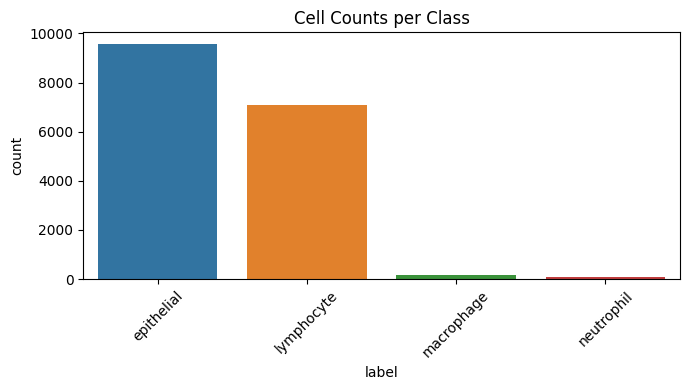

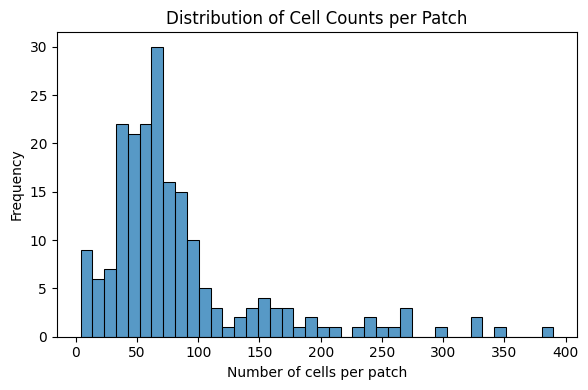

In [7]:
from collections import Counter
import seaborn as sns

patch_dir = PATCH_ROOT / "images"
label_dir = PATCH_ROOT / "labels"
meta_dir  = PROC_ROOT / "_meta"
meta_dir.mkdir(exist_ok=True)

records = []
class_counter = Counter()

for csv_file in sorted(label_dir.glob("*.csv")):
    base = csv_file.stem
    img_path = patch_dir / f"{base}.png"
    if not img_path.exists():
        continue

    df = pd.read_csv(csv_file, header=None, names=["x", "y", "class"])
    num_cells = len(df)
    class_counts = df["class"].value_counts().to_dict()

    for cls, n in class_counts.items():
        class_counter[int(cls)] += n

    records.append({
        "patch": base,
        "num_cells": num_cells,
        "unique_classes": list(class_counts.keys()),
        "empty": num_cells == 0
    })

summary_df = pd.DataFrame(records)
summary_df.to_csv(meta_dir / "dataset_summary.csv", index=False)
print(f"Saved summary: {meta_dir / 'dataset_summary.csv'}")

# --- Overview stats ---
total_patches = len(summary_df)
empty_patches = summary_df["empty"].sum()
print(f"Total patches: {total_patches}")
print(f"Empty patches: {empty_patches} ({empty_patches/total_patches:.1%})")

# --- Class distribution ---
class_df = pd.DataFrame.from_dict(class_counter, orient="index", columns=["count"])
class_df["label"] = class_df.index.map(lambda i: class_map.get(str(i), "unknown"))
class_df = class_df.sort_index()

plt.figure(figsize=(7,4))
sns.barplot(x="label", y="count", data=class_df, palette="tab10")
plt.title("Cell Counts per Class")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# --- Cells per patch distribution ---
plt.figure(figsize=(6,4))
sns.histplot(summary_df["num_cells"], bins=40, kde=False)
plt.title("Distribution of Cell Counts per Patch")
plt.xlabel("Number of cells per patch")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()


<a id="step5"></a>
# Step 5: Dataset Integrity + Overview

In [ ]:
from collections import Counter
import pandas as pd
import numpy as np

print("🔍 Checking dataset integrity...")

images_dir = PATCH_ROOT / "images"
labels_dir = PATCH_ROOT / "labels"

image_files = sorted(f.stem for f in images_dir.glob("*.png"))
label_files = sorted(f.stem for f in labels_dir.glob("*.csv"))

# 1️⃣  File pairing
unmatched_images = set(image_files) - set(label_files)
unmatched_labels = set(label_files) - set(image_files)

print(f"Total images: {len(image_files)}")
print(f"Total labels: {len(label_files)}")
if unmatched_images:
    print(f"⚠️ {len(unmatched_images)} images without labels.")
if unmatched_labels:
    print(f"⚠️ {len(unmatched_labels)} labels without images.")

# 2️⃣  Validate CSV content (quick sample)
empty_labels = []
class_counter = Counter()
for csv_path in labels_dir.glob("*.csv"):
    try:
        data = np.loadtxt(csv_path, delimiter=",")
        if data.ndim == 1 and data.size == 0:
            empty_labels.append(csv_path.name)
        else:
            # 3rd column = class id
            cls = data[:, 2].astype(int) if data.ndim > 1 else []
            class_counter.update(cls.tolist())
    except Exception:
        empty_labels.append(csv_path.name)

print(f"Empty label files: {len(empty_labels)}")
if empty_labels:
    print("Example empty files:", empty_labels[:3])

# 3️⃣  Patch count per patient
# Ensure file stems are strings
file_series = pd.Series([str(f) for f in image_files])

patient_counts = (
    file_series
    .str.extract(r"(TCGA-[0-9A-Z-]+)")
    .dropna()[0]
    .value_counts()
)

print("\nPatch count per patient (top 5):")
print(patient_counts.head())


# 4️⃣  Class totals
print("\nClass pixel count summary:")
for cid, count in class_counter.items():
    name = class_map.get(str(cid), f"id_{cid}")
    print(f"  {cid} ({name}): {count}")

# 5️⃣  Save summary CSV
summary_path = PROC_ROOT / "_meta" / "final_summary.csv"
pd.DataFrame.from_dict(class_counter, orient="index", columns=["count"]).to_csv(summary_path)
print(f"\n✅ Final summary saved to: {summary_path}")


🔍 Checking dataset integrity...
Total images: 200
Total labels: 200
Empty label files: 0

Patch count per patient (top 5):
TCGA-B9-A8YI-01Z-00-DX1      12
TCGA-S3-AA11-01Z-00-DX1      12
TCGA-D8-A1X5-01Z-00-DX2      11
TCGA-E9-A22B-01Z-00-DX1      10
TCGA-EJ-5517-01Z-00-DX1-4     9
Name: 0, dtype: int64

Class pixel count summary:
  1 (epithelial): 9569
  2 (lymphocyte): 7080
  4 (neutrophil): 100
  3 (macrophage): 181

✅ Final summary saved to: /projectnb/ec500kb/projects/Fall_2025_Projects/Project_2/AI-guided-whole-slide-imaging-analysis/ProcessedDataset/v1_40x_area20/_meta/final_summary.csv
